In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
warnings.filterwarnings("ignore")

##  I. Goal

The notebook demonstrates examples for implementing models by instructing it how to arrive at the output 

## II. Usecase 1: The model prediction must be a decreasing (or increasing) function of x1

An example for implementing this usecase is the Boston Housing toy dataset imported from sklearn datasets. It has 506 rows and 13 attributes.To implement use case 1 we will create two XGBoost models one with no directional constraints and the second with a directional constraint on the RM attribute. Our assumption is that median value of homes should be an increasing function of Average number of rooms per dwelling. 

In [3]:
boston_dataset = load_boston()
print(boston_dataset.keys())

dict_keys(['target', 'feature_names', 'data', 'DESCR'])


Boston Housing dataset description:

In [4]:
print(boston_dataset.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
boston['MEDV'] = boston_dataset.target

In [7]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [8]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


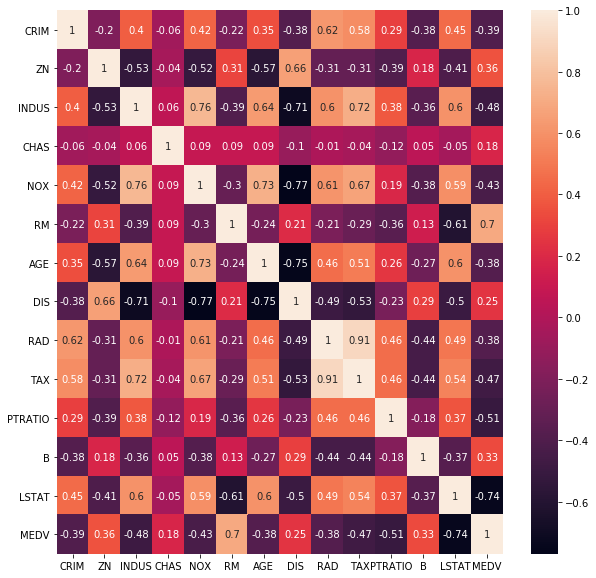

In [9]:
correlation_matrix = boston.corr().round(2)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data=correlation_matrix, annot=True, ax=ax)

Figure 1: Correlation Matrix of Boston Housing dataset. It can be seen that the variable RM which is average number of rooms per dweling has a high correlation of 0.7 with the target varible in this dataset. 

In [10]:
# Read data and split into train test sets 
X, y = boston.iloc[:,:-1], boston.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [12]:
def print_results(result):
     
    """
    The function takes in a fitted model and prints the best params and training and test set performance 
    """
    
    print("XGB Model best params : {}".format(result.best_params_))
    
    ypred_train = res.predict(X_train)
    mse_train = mean_squared_error(y_train, ypred_train)
    print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))
    
    ypred_test = res.predict(X_test)
    mse_test = mean_squared_error(y_test, ypred_test)
    print(" Test RMSE: %.5f" % (mse_test**(1/2.0)))

### XGB Model with no directional constraints

In [18]:
param_grid = {
                'max_depth':range(2,7), 
                'learning_rate': [.03, 0.05, .07], 
                'seed': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [100, 120, 130, 150]
}

xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid,cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.9s finished


In [19]:
print_results(res)

XGB Model best params : {'seed': 123, 'learning_rate': 0.07, 'n_estimators': 150, 'objective': 'reg:squarederror', 'max_depth': 3}
 Train RMSE: 1.37155
 Test RMSE: 2.84425


### XGB Model with directional constraint

In [15]:
feature_monotones = [0] * (X_train.shape[1])
feature_monotones[5] = 1

In [20]:
param_grid2 = {
          'max_depth':range(2,7), 
          'learning_rate': [.03, 0.05, .07], 
          'seed': [123],
          'objective':['reg:squarederror'], 
          'n_estimators': [100, 120, 130, 150], 
          'monotone_constraints': ['(' + ','.join([str(m) for m in feature_monotones]) + ')'], 
         }

xgbr2 = xgb.XGBRegressor()
gr2 = GridSearchCV(xgbr2,param_grid=param_grid2,cv=5, verbose=True)
res2 = gr2.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   30.4s finished


In [21]:
print_results(res2)

XGB Model best params : {'seed': 123, 'n_estimators': 150, 'objective': 'reg:squarederror', 'max_depth': 4, 'monotone_constraints': '(0,0,0,0,0,1,0,0,0,0,0,0,0)', 'learning_rate': 0.05}
 Train RMSE: 1.37155
 Test RMSE: 2.84425


Given the dataset size both models overfit the data and give the same performnance on the training and test set. For this example, the bottom line is that adding monotonicity constraint does not significantly hurt the performance and is consistent with the logic that house prices should increase with increase in number of rooms. 

## II. Usecase 3: The model prediction must not be too sensitive to x3

An example for implementing this usecase is predicting insurance costs from demographic and region information. The dataset has 1338 rows and 7 attributes. Our assumption is that the individual attributes such as age and bmi should have more predictive power than the geographical region of the individual. 

In [22]:
insurance_df = pd.read_csv("data/insurance.csv")
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [23]:
insurance_df.shape

(1338, 7)

In [24]:
insurance_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [25]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [26]:
X, y = insurance_df.iloc[:,:-1], insurance_df.iloc[:,-1]
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [28]:
rfr=RandomForestRegressor(random_state=42, verbose=1, n_jobs=-1, n_estimators= 200)
res = rfr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


In [29]:
ypred_train = res.predict(X_train)
mse_train = mean_squared_error(y_train, ypred_train)
print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))
    
ypred_test = res.predict(X_test)
mse_test = mean_squared_error(y_test, ypred_test)
print(" Test RMSE: %.5f" % (mse_test**(1/2.0)))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


 Train RMSE: 1857.35494
 Test RMSE: 4700.84264


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [23]:
model1_columns = ['age', 'bmi', 'children', 'sex_male', 'smoker_yes']
X_train_sub = X_train[model1_columns]